In [1]:
import h5py
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import lcpfn 
from lcpfn import bar_distribution, encoders, train
from lcpfn import train as lctrain

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

### Load LCDB 1.1 data

In [2]:
### hyperparameter
OPENML_ID = {0: '3', 1: '6', 2: '11', 3: '12', 4: '13', 5: '14', 6: '15', 7: '16', 8: '18', 9: '21', 10: '22', 11: '23', 12: '24', 13: '26', 14: '28', 15: '29', 16: '30', 17: '31', 18: '32', 19: '36', 20: '37', 21: '38', 22: '44', 23: '46', 24: '50', 25: '54', 26: '55', 27: '57', 28: '60', 29: '61', 30: '151', 31: '179', 32: '180', 33: '181', 34: '182', 35: '184', 36: '185', 37: '188', 38: '201', 39: '273', 40: '293', 41: '299', 42: '300', 43: '307', 44: '336', 45: '346', 46: '351', 47: '354', 48: '357', 49: '380', 50: '389', 51: '390', 52: '391', 53: '392', 54: '393', 55: '395', 56: '396', 57: '398', 58: '399', 59: '401', 60: '446', 61: '458', 62: '469', 63: '554', 64: '679', 65: '715', 66: '718', 67: '720', 68: '722', 69: '723', 70: '727', 71: '728', 72: '734', 73: '735', 74: '737', 75: '740', 76: '741', 77: '743', 78: '751', 79: '752', 80: '761', 81: '772', 82: '797', 83: '799', 84: '803', 85: '806', 86: '807', 87: '813', 88: '816', 89: '819', 90: '821', 91: '822', 92: '823', 93: '833', 94: '837', 95: '843', 96: '845', 97: '846', 98: '847', 99: '849', 100: '866', 101: '871', 102: '881', 103: '897', 104: '901', 105: '903', 106: '904', 107: '910', 108: '912', 109: '913', 110: '914', 111: '917', 112: '923', 113: '930', 114: '934', 115: '953', 116: '958', 117: '959', 118: '962', 119: '966', 120: '971', 121: '976', 122: '977', 123: '978', 124: '979', 125: '980', 126: '991', 127: '993', 128: '995', 129: '1000', 130: '1002', 131: '1018', 132: '1019', 133: '1020', 134: '1021', 135: '1036', 136: '1040', 137: '1041', 138: '1042', 139: '1049', 140: '1050', 141: '1053', 142: '1056', 143: '1063', 144: '1067', 145: '1068', 146: '1069', 147: '1083', 148: '1084', 149: '1085', 150: '1086', 151: '1087', 152: '1088', 153: '1116', 154: '1119', 155: '1120', 156: '1128', 157: '1130', 158: '1134', 159: '1138', 160: '1139', 161: '1142', 162: '1146', 163: '1161', 164: '1166', 165: '1216', 166: '1233', 167: '1235', 168: '1236', 169: '1441', 170: '1448', 171: '1450', 172: '1457', 173: '1461', 174: '1462', 175: '1464', 176: '1465', 177: '1468', 178: '1475', 179: '1477', 180: '1478', 181: '1479', 182: '1480', 183: '1483', 184: '1485', 185: '1486', 186: '1487', 187: '1488', 188: '1489', 189: '1494', 190: '1497', 191: '1499', 192: '1501', 193: '1503', 194: '1509', 195: '1510', 196: '1515', 197: '1566', 198: '1567', 199: '1575', 200: '1590', 201: '1592', 202: '1597', 203: '4134', 204: '4135', 205: '4137', 206: '4534', 207: '4538', 208: '4541', 209: '6332', 210: '23381', 211: '23512', 212: '23517', 213: '40498', 214: '40499', 215: '40664', 216: '40668', 217: '40670', 218: '40672', 219: '40677', 220: '40685', 221: '40687', 222: '40701', 223: '40713', 224: '40900', 225: '40910', 226: '40923', 227: '40927', 228: '40966', 229: '40971', 230: '40975', 231: '40978', 232: '40979', 233: '40981', 234: '40982', 235: '40983', 236: '40984', 237: '40994', 238: '40996', 239: '41027', 240: '41142', 241: '41143', 242: '41144', 243: '41145', 244: '41146', 245: '41150', 246: '41156', 247: '41157', 248: '41158', 249: '41159', 250: '41161', 251: '41163', 252: '41164', 253: '41165', 254: '41166', 255: '41167', 256: '41168', 257: '41169', 258: '41228', 259: '41972', 260: '42734', 261: '42742', 262: '42769', 263: '42809', 264: '42810'}
LEARNER_ZOO = {0: 'SVC_linear', 1: 'SVC_poly', 2: 'SVC_rbf', 3: 'SVC_sigmoid', 4: 'Decision Tree', 5: 'ExtraTree', 6: 'LogisticRegression', 7: 'PassiveAggressive', 8: 'Perceptron', 9: 'RidgeClassifier', 10: 'SGDClassifier', 11: 'MLP', 12: 'LDA', 13: 'QDA', 14: 'BernoulliNB', 15: 'MultinomialNB', 16: 'ComplementNB', 17: 'GaussianNB', 18: 'KNN', 19: 'NearestCentroid', 20: 'ens.ExtraTrees', 21: 'ens.RandomForest', 22: 'ens.GradientBoosting', 23: 'DummyClassifier'}
ANCHOR_SIZE = np.ceil(16 * 2 ** ((np.arange(137)) / 8)).astype(int)

### load data: validation accuracy
lc_data = h5py.File(Path.cwd() / 'dataset/LCDB11_ACC_265_noFS_raw.hdf5', 'r')['accuracy'][...][:,:,:,:,:,1]

mean_valid_lc_nofs =np.nanmean(lc_data, axis=(2, 3))

Train data shape: (5300, 1, 137)
Test data UD shape: (1325, 1, 137)
Test data UL shape: (5300, 1, 137)
Test data UDUL shape: (1325, 1, 137)


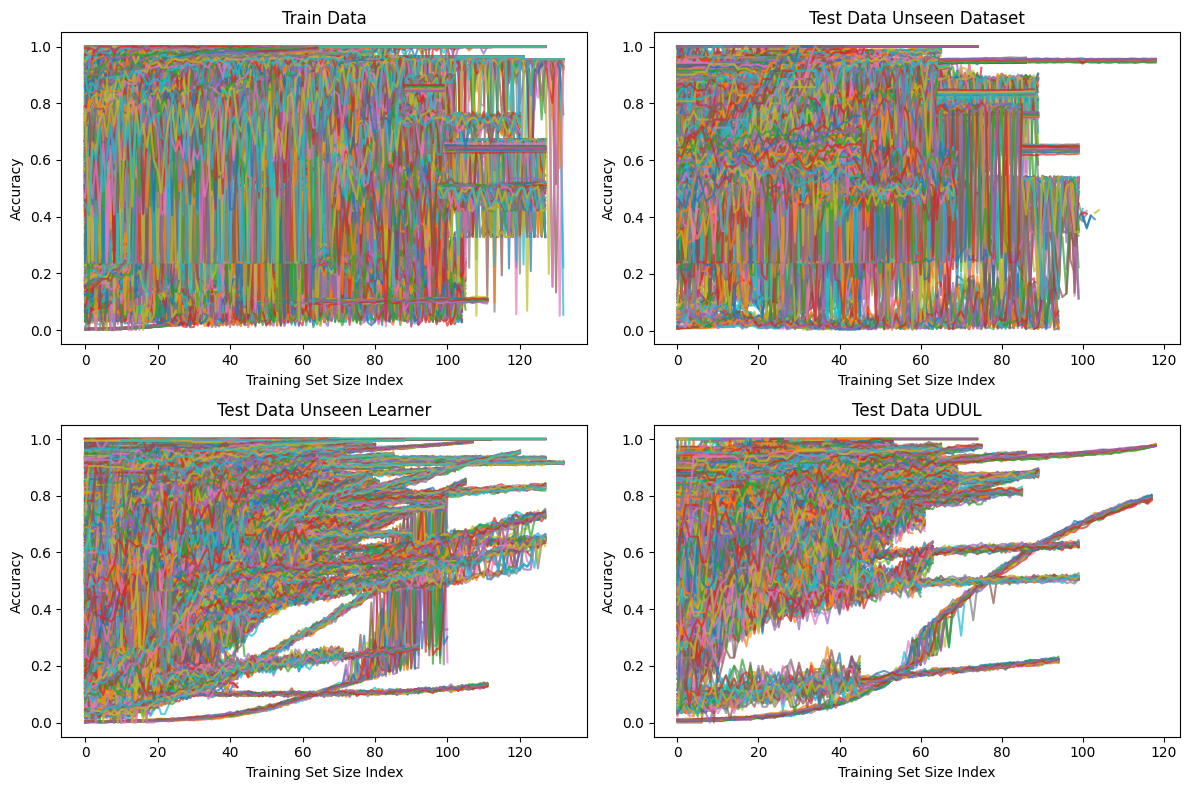

In [3]:
### dataset split
data_split_state = 42
trained_on = "Neighbors"
eval_on = "Neighbors"
train_data_indices, test_data_indices = train_test_split(np.arange(len(OPENML_ID)), 
                                                         test_size=0.2, 
                                                         random_state=data_split_state)

groups = {
    "SVC": [0, 1, 2, 3],
    "Trees": [4, 5, 20, 21, 22],
    "NB": [14, 15, 16, 17],
    "Neighbors": [18, 19],
    "DA": [12, 13],
    "Linear": [6, 7, 8, 9, 10],
    "nn": [11],
    "Dummy": [23]
}

### learner split
train_learner_indices = np.array(groups[trained_on])    
test_learner_indices = np.array(groups[eval_on])         

### UD, UL, UDUL
train_data = lc_data[train_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UD = lc_data[test_data_indices][:, train_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UL = lc_data[train_data_indices][:, test_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)
test_data_UDUL = lc_data[test_data_indices][:, test_learner_indices, :].transpose(0, 2, 3, 1, 4).reshape(-1, 1, 137)

print(f"Train data shape: {train_data.shape}")  
print(f"Test data UD shape: {test_data_UD.shape}")
print(f"Test data UL shape: {test_data_UL.shape}")
print(f"Test data UDUL shape: {test_data_UDUL.shape}")


def plot_learning_curves(ax, data, title):
    for idx in range(len(data)):  
        ax.plot(data[idx, 0, :], linestyle='-', alpha=0.7)

    ax.set_xlabel("Training Set Size Index")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_learning_curves(axes[0, 0], train_data, "Train Data")
plot_learning_curves(axes[0, 1], test_data_UD, "Test Data Unseen Dataset")
plot_learning_curves(axes[1, 0], test_data_UL, "Test Data Unseen Learner")
plot_learning_curves(axes[1, 1], test_data_UDUL, "Test Data UDUL")
plt.tight_layout()
plt.show()

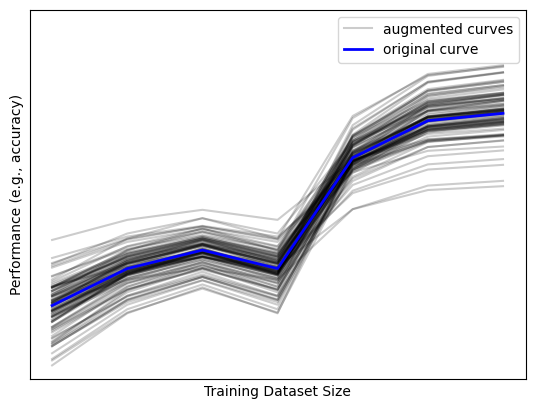

In [4]:
def augment(y, n_anchors):
    y_min = np.nanmin(y)
    y_max = np.nanmax(y)
    if y_min >= y_max:
        return y
    anchors = np.random.uniform(0,1,(n_anchors,))
    anchors.sort()
    min_diff = 10**10
    y_final = None
    for i in range(n_anchors):
        a_i = anchors[i]
        for j in range(i+1, n_anchors):
            a_j = anchors[j]
            y_transformed = (a_j - a_i) / (y_max - y_min) * (y - y_min) + a_i
            error = np.nansum((y - y_transformed)**2)
            if error < min_diff:
                min_diff = error
                y_final = y_transformed
                #print(f"{y_transformed} ([{a_i},{a_j}], error: {error})")
    return y_final
    
y = np.array([0.2,0.3, 0.35, 0.3, 0.6, 0.7, 0.72])
for i in range(100):
    yy = augment(y, n_anchors=10)
    if i==0:
        plt.plot(yy,color="k",alpha=0.2, label="augmented curves")
    else:
        plt.plot(yy,color="k",alpha=0.2)
ax = plt.gca()

# Hide X and Y axes label marks
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)

# Hide X and Y axes tick marks
ax.set_xticks([])
ax.set_yticks([])
plt.xlabel("Training Dataset Size")
plt.ylabel("Performance (e.g., accuracy)")
plt.ylim([0,1])
plt.plot(y,color="blue", linewidth=2, label="original curve")
plt.legend()

### Training LC-PFN Model

In [5]:
lcdb_curves = []
lcdb_curve_lengths = []

for i in range(train_data.shape[0]):  
    curve = train_data[i, 0, :]  
    curve_length = np.count_nonzero(~np.isnan(curve)) 
    
    if curve_length > 0:  
        lcdb_curves.append(curve)
        lcdb_curve_lengths.append(curve_length)

print(f"Training set size: {len(lcdb_curves)} curves")


Training set size: 5275 curves


In [6]:
# create a single eval pos, seq len samplers
class LCDB_samplers():
    # pick a training task, note that if multiple training tasks have the same length curves, the eventual batch will contain a mixture

    def __init__(self, rng=np.random, verbose=False):
        self.rng = rng
        self.curve_length = None
        self.verbose = verbose

    def seq_len(self):
        self.curve_length = self.rng.choice(lcdb_curve_lengths)
        if self.verbose:
            print(f"curve length: {self.curve_length}")
        return self.curve_length

    def single_eval_pos(self):
        sep = self.rng.randint(self.curve_length)
        if self.verbose:
            print(f"single eval pos: {sep}")
        return sep

lcdb_sampler = LCDB_samplers(verbose=False)

for _ in range(3):
    print((lcdb_sampler.seq_len(), lcdb_sampler.single_eval_pos()))

(np.int64(57), 0)
(np.int64(63), 27)
(np.int64(80), 18)


use data augmentation or not

In [8]:
AUGMENT = True

In [9]:
# generating batches from the LCDB dataset
def get_batch_lcdb_real( batch_size, seq_len, num_features, device="cpu", noisy_target=True, **_ ):
    assert num_features == 1
    assert noisy_target

    ###### sample the curve data
    x = np.empty((batch_size, seq_len), dtype=float)
    y_target = np.empty((batch_size, seq_len), dtype=float)
    y_noisy = np.empty((batch_size, seq_len), dtype=float)

    # determine a list of cids having the desired curve length (TODO: precompute)
    candidates = [cid for (cid, clen) in enumerate(lcdb_curve_lengths) if clen == seq_len]
    cids = np.random.choice(candidates, batch_size)

    for i, cid in enumerate(cids):
        curve = lcdb_curves[cid]
        if AUGMENT:
            curve = augment(curve,n_anchors=10)
        token_idx = 0
        for j, y in enumerate(curve):
            if np.isnan(y):
                continue
            else:
                x[i, token_idx] = j+1
                y_target[i, token_idx] = y
                y_noisy[i, token_idx] = y
                token_idx += 1
        assert(token_idx == seq_len)

    # turn numpy arrays into correctly shaped torch tensors & move them to device
    x = (torch.arange(1, seq_len + 1).repeat((num_features, batch_size, 1)).transpose(2, 0).to(device))
    y_target = torch.from_numpy(y_target).transpose(1, 0).to(device)
    y_noisy = torch.from_numpy(y_noisy).transpose(1, 0).to(device)

    # changes
    x = x.float()
    y_target = y_target.float()
    y_noisy = y_noisy.float()

    return x, y_noisy, y_target

def train_lcdbpfn(get_batch_func, seq_len, emsize, nlayers, num_borders, lr, batch_size, epochs):
    
    # training hyperparameters
    hps = {}
    
    # PFN training hyperparameters
    dataloader = lcpfn.priors.utils.get_batch_to_dataloader(get_batch_func)  # type: ignore
    
    num_features = 1
    
    ys = []
    for curve in lcdb_curves:
        ys.extend(curve)
    
    ys = torch.FloatTensor(ys)
    ys = torch.normal(ys,1e-5)
    
    bucket_limits = bar_distribution.get_bucket_limits(num_borders, ys=ys)
    #print(bucket_limits)
    
    # Discretization of the predictive distributions
    criterions = {
        num_features: {
            num_borders: bar_distribution.FullSupportBarDistribution(bucket_limits)
        }
    }
    
    
    config = dict(
        nlayers=nlayers,
        priordataloader_class=dataloader,
        criterion=criterions[num_features][num_borders],
        encoder_generator=lambda in_dim, out_dim: torch.nn.Sequential(
            encoders.Normalize(0.0, 101.0),
            encoders.Normalize(0.5, math.sqrt(1 / 12)),
            encoders.Linear(in_dim, out_dim),
        ),
        emsize=emsize,
        nhead=(emsize // 128),
        warmup_epochs=(epochs // 4),
        y_encoder_generator=encoders.get_normalized_uniform_encoder(encoders.Linear),
        batch_size=batch_size,
        scheduler=lcpfn.utils.get_cosine_schedule_with_warmup,
        extra_prior_kwargs_dict={
            # "num_workers": 10,
            "num_features": num_features,
            "hyperparameters": {
                **hps,
            },
        },
        epochs=epochs,
        lr=lr,
        bptt=seq_len,
        # seq_len_gen=lcdb_sampler.seq_len,
        single_eval_pos_gen=lcdb_sampler.single_eval_pos,
        aggregate_k_gradients=1,
        nhid=(emsize * 2),
        steps_per_epoch=100,
        train_mixed_precision=False,
    )
    
    return lctrain.train(**config)

In [10]:
# local training
EPOCH = 300

result = train_lcdbpfn(
    get_batch_func = get_batch_lcdb_real,
    seq_len = 80,   # 80 is better than 50
    emsize = 128,
    nlayers = 3,
    num_borders = 1000,
    lr = 0.0001,
    batch_size = 20,
    epochs = EPOCH 
)

Using 332000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using cpu:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 20, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x0000018BD8226660>, 'seq_len_maximum': 80, 'device': 'cpu:0', 'num_features': 1, 'hyperparameters': {}}, 'num_features': 1}
Style definition: None
Using a Transformer with 0.69 M parameters
----------------------------------------------------------------------
| end of epoch   1 | lr 0.0 | mean loss NLL -0.06 | 
----------------------------------------------------------------------
| end of epoch   2 | lr 1.3333333333333334e-06 | mean loss NLL -0.06 | 
----------------------------------------------------------------------
| end of epoch   3 | lr 2.666666666666667e-06 | mean loss NLL -0.07 | 
----------------------------------------------------------------------
| end of epoch   4 | lr 4.000000000000001e-06 | m

<function matplotlib.pyplot.show(close=None, block=None)>

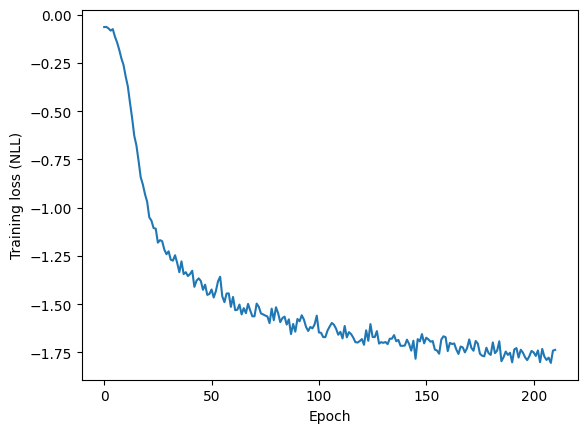

In [11]:
plt.figure()
plt.plot(result[-1])
plt.xlabel('Epoch')
plt.ylabel('Training loss (NLL)')
plt.show

In [ ]:
model = result[2]  
torch.save(model, f'lcpfn_model_{EPOCH}.pth')
print("Model saved successfully!")

Model saved successfully!
